# <소비자 데이터를 통하여 소비량 예측>



## 1. 사전 준비


In [ ]:
from google.colab import drive #구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd #패키지 설치
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

##2. 데이터 전처리

In [ ]:
#csv 형식의 training 데이터를 로드
train = pd.read_csv('/content/drive/MyDrive/MLstudy/1/train.csv')
#데이터 살펴보기 위해 데이터 최상단의 5줄을 표시
train.head() 

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,8,7,0,0,0,0,0,0,0,541
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,7,1,1,0,0,0,0,0,0,899
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,9,3,0,0,0,0,0,0,0,901
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,3,8,0,0,0,0,0,0,0,50
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,5,7,0,0,0,1,0,0,0,444


결측치(NA: Not Available) 확인

In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


일자 분리: Dt_Customer(string)-> 년, 월, 일 숫자형으로 변환

In [ ]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,...,0,0,1,0,0,0,444,10,6,2014


In [ ]:
train = train.drop('Dt_Customer', axis = 1) #삭제
train.shape ## (행, 열)

(1108, 24)

카테고리형 데이터 인코딩  
카테고리형(Education, Marital_Status)을 Label Encoding을 이용해 숫자형으로 변환

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1108 non-null   int64  
 1   Year_Birth           1108 non-null   int64  
 2   Education            1108 non-null   object 
 3   Marital_Status       1108 non-null   object 
 4   Income               1108 non-null   float64
 5   Kidhome              1108 non-null   int64  
 6   Teenhome             1108 non-null   int64  
 7   Recency              1108 non-null   int64  
 8   NumDealsPurchases    1108 non-null   int64  
 9   NumWebPurchases      1108 non-null   int64  
 10  NumCatalogPurchases  1108 non-null   int64  
 11  NumStorePurchases    1108 non-null   int64  
 12  NumWebVisitsMonth    1108 non-null   int64  
 13  AcceptedCmp3         1108 non-null   int64  
 14  AcceptedCmp4         1108 non-null   int64  
 15  AcceptedCmp5         1108 non-null   i

In [ ]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            #dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

train = label_encoder(train, make_label_map(train))
train.head()

,id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target,year,month,day
0,0,1974,0,0,46014.0,1,1,21,10,7,...,0,0,0,0,0,0,541,21,1,2013
1,1,1962,1,1,76624.0,0,1,68,1,5,...,0,0,0,0,0,0,899,24,5,2014
2,2,1951,1,2,75903.0,0,1,50,2,6,...,0,0,0,0,0,0,901,8,4,2013
3,3,1974,2,2,18393.0,1,0,2,2,3,...,0,0,0,0,0,0,50,29,3,2014
4,4,1946,3,0,64014.0,2,1,56,7,8,...,0,0,1,0,0,0,444,10,6,2014


## 3. 데이터 가공

1)  변수 간 상관관계 확인 (Feature Correlation)  
피어슨 상관계수 이용

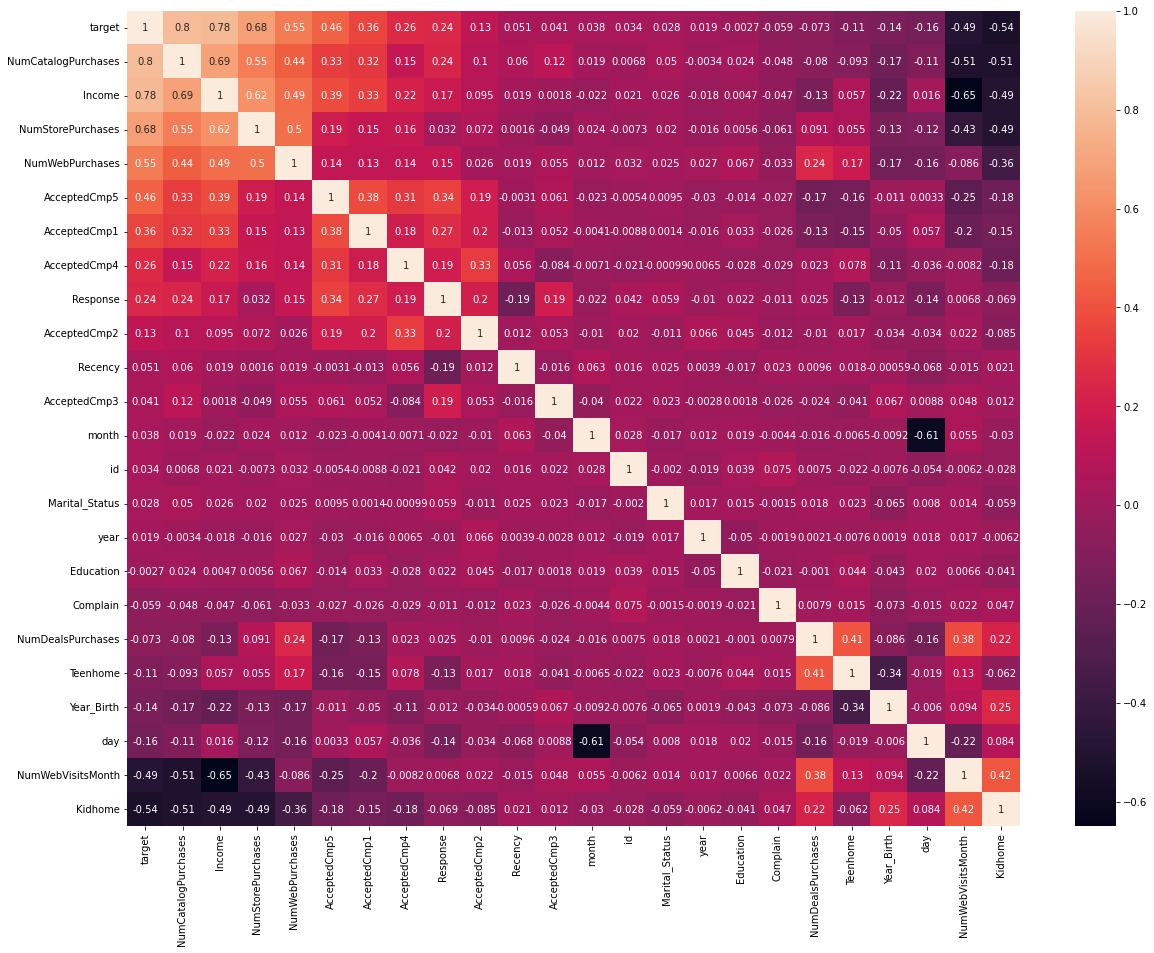

In [ ]:
import seaborn as sns
corr=train.corr()
top_corr=train[corr.nlargest(40,'target')['target'].index].corr() 
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

In [ ]:
train["AcceptedCmpt"]=train["AcceptedCmp2"]+train["AcceptedCmp3"]+train["Response"]

corr=train.corr()

In [ ]:
corr["target"].sort_values(ascending=False) # target을 기준으로 연관성 조사

target                 1.000000
NumCatalogPurchases    0.798065
Income                 0.784084
NumStorePurchases      0.677785
NumWebPurchases        0.546082
AcceptedCmp5           0.458208
AcceptedCmp1           0.361102
AcceptedCmp4           0.256784
Response               0.242760
AcceptedCmpt           0.219187
AcceptedCmp2           0.129995
Recency                0.050873
AcceptedCmp3           0.040736
month                  0.037649
id                     0.034192
Marital_Status         0.027954
year                   0.018917
Education             -0.002718
Complain              -0.058704
NumDealsPurchases     -0.072802
Teenhome              -0.109214
Year_Birth            -0.136035
day                   -0.159404
NumWebVisitsMonth     -0.488252
Kidhome               -0.538365
Name: target, dtype: float64

상관관계 낮은 feature 제거

In [ ]:
train = train.drop(['AcceptedCmp2','Recency' ,'AcceptedCmp3','month','Marital_Status','year','Education','Complain','NumDealsPurchases','Teenhome','Year_Birth','day'], axis = 1) #삭제
train.shape ## (행, 열)

(1108, 13)

2) 이상치 제거

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

이상치 확인

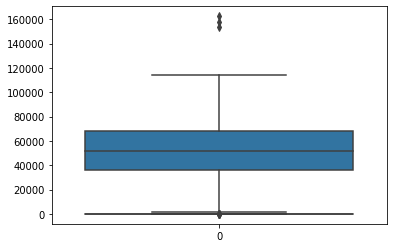

In [ ]:
sns.boxplot(data=train['NumCatalogPurchases'])
sns.boxplot(data=train['Income'])

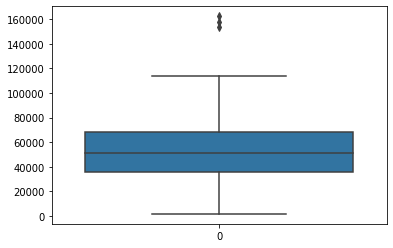

In [ ]:
sns.boxplot(data=train['Income'])

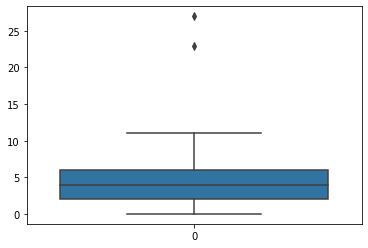

In [ ]:
sns.boxplot(data=train['NumWebPurchases'])

이상치 제거

In [ ]:
outlier_idx = get_outlier(df=train, column='NumCatalogPurchases', weight=1.5)
train.drop(outlier_idx, axis=0, inplace=True)
outlier_idx = get_outlier(df=train, column='Income', weight=1.5)
train.drop(outlier_idx, axis=0, inplace=True)
outlier_idx = get_outlier(df=train, column='NumWebPurchases', weight=1.5)
train.drop(outlier_idx, axis=0, inplace=True)

##4. 변수 및 모델 정의
 독립변수(X: 소비데이터)와 종속변수(y:소비량) 로 나누어 준다


In [ ]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 소비량 추출

In [ ]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.3) #30프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

 train set-> train_data(70%) val_data(30%)

In [ ]:
print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (765, 13)
검증할 val 셋 :  (329, 13)


In [ ]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 소비량 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #training 데이터에서 소비량 추출

## 5. 다항선형회귀 모델을 사용

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.01,
                         max_depth=7, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1))

models.append(XGBRegressor(n_estimators=3300, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_data_X, train_data_y)

[07:01:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(models) ## 사용된 모델 확인

[LGBMRegressor(bagging_fraction=0.7, colsample_bytree=0.5, feature_fraction=0.9,
              learning_rate=0.01, max_depth=7, n_estimators=3300, reg_lambda=5,
              subsample=0.7), XGBRegressor(learning_rate=0.01, max_depth=7, n_estimators=3300, subsample=0.75)]


##8. Soft-Voting 구현


In [ ]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(val_data_X)
    else:
        prediction += model.predict(val_data_X)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.1771392635401423


## 9. 예측값 눈으로 확인하기

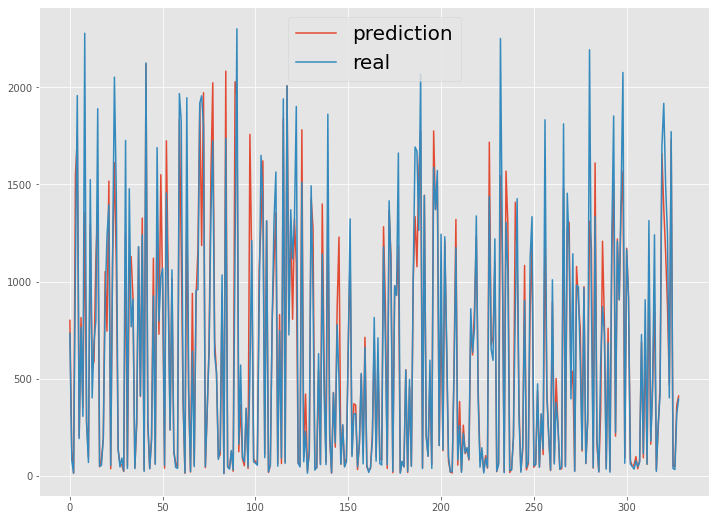

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 9))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

## 10. train 셋 + val 셋 100% 활용하는 모델 만들기


In [ ]:
train_X = train.drop(['target', 'id'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 소비량 추출

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(LGBMRegressor(n_estimators=3300, bagging_fraction=0.7, learning_rate=0.01,
                         max_depth=7, subsample=0.7, feature_fraction=0.9, boosting_type='gbdt',
                         colsample_bytree=0.5, reg_lambda=5, n_jobs=-1))

models.append(XGBRegressor(n_estimators=3300, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_X, train_y)

[07:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/MLstudy/1/test.csv') # 데이터를 불러온 뒤

check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리

test = test.drop('Dt_Customer', axis = 1) #필요없는 열 삭제

#새로운 컬럼을 생성
test['year'] = year 
test['month'] = month
test['day'] = day
test["AcceptedCmpt"]  =test["AcceptedCmp2"] + test["AcceptedCmp3"] + test["Response"]
test = test.drop(['AcceptedCmp2','Recency' ,'AcceptedCmp3','month','Marital_Status','year','Education','Complain','NumDealsPurchases','Teenhome','Year_Birth','day'], axis = 1) #삭제
test = label_encoder(test, make_label_map(test)) #카테고리형 피쳐 라벨인코딩

test = test.drop(['id'], axis = 1) #training 데이터에서 피쳐 추출

test.head()

결측치가 존재하지 않습니다


,Income,Kidhome,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Response,AcceptedCmpt
0,57537.0,1,4,3,8,4,0,0,0,0,0
1,65748.0,0,2,4,10,1,0,0,0,0,0
2,55434.0,1,5,3,13,4,0,0,0,0,0
3,67716.0,0,7,4,13,5,1,0,0,0,0
4,85606.0,0,6,7,9,3,0,0,1,0,0


In [ ]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
pred = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if pred is None:
        pred = model.predict(test)
    else:
        pred += model.predict(test)
        
# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
pred /= len(models)

In [ ]:
pred

array([ 430.52132574,  828.58285278,  822.80631079, ...,   60.8393154 ,
       1283.84687509,  140.55532894])

## 11. Dacon 대회에 제출하기 (Submission)


In [ ]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('/content/drive/MyDrive/MLstudy/1/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,430.521326
1,1,828.582853
2,2,822.806311
3,3,1196.764234
4,4,1249.733161


In [ ]:
submission.to_csv("sumin.csv", index=False)